# Federated Learning (FedAvg) with Communication Compression - HAR

This notebook implements **FedAvg with Communication Compression** for UCI HAR dataset.

**Experiment Configuration:**
- Dataset: UCI HAR (Human Activity Recognition)
- Training Mode: Federated Learning (FedAvg)
- **Compression**: Top-K Sparsification (k=10%)
- **Ablation**: With/Without Compression
- Non-IID α: [0.1, 0.3, 1.0]
- Seeds: [42, 123, 456]
- Total Runs: 18 (3 α × 3 seeds × 2 compression modes)
- Epochs: 100 rounds
- Number of Clients: 10
- Clients per Round: 5

**Dataset Source:** https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones

**Compatible with:** Local environment and Kaggle

## 1. Environment Setup

In [1]:
import os

IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    print("Running on Kaggle")
    DATA_PATH = '/kaggle/input/human-activity-recognition-with-smartphones'
else:
    print("Running locally")
    DATA_PATH = '.'

print(f"Data path: {DATA_PATH}")

Running on Kaggle
Data path: /kaggle/input/human-activity-recognition-with-smartphones


## 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import json
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch: {torch.__version__}, NumPy: {np.__version__}, Pandas: {pd.__version__}")

PyTorch: 2.6.0+cu124, NumPy: 1.26.4, Pandas: 2.2.3


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeds set to: {seed}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cpu


## 3. Data Loading

In [4]:
class UCIHARDataLoader:
    def __init__(self, data_path='.'):
        self.data_path = data_path
        self.label_encoder = LabelEncoder()
        self.activity_labels = None
        
    def load_data(self):
        train_df = pd.read_csv(os.path.join(self.data_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(self.data_path, 'test.csv'))
        
        X_train = train_df.drop(['Activity', 'subject'], axis=1).values
        y_train = train_df['Activity'].values
        X_test = test_df.drop(['Activity', 'subject'], axis=1).values
        y_test = test_df['Activity'].values
        
        self.label_encoder.fit(np.concatenate([y_train, y_test]))
        y_train = self.label_encoder.transform(y_train)
        y_test = self.label_encoder.transform(y_test)
        
        self.activity_labels = {i: label for i, label in enumerate(self.label_encoder.classes_)}
        return X_train, y_train, X_test, y_test
    
    def partition_data_dirichlet(self, X, y, num_clients, alpha, seed=42):
        np.random.seed(seed)
        num_classes = len(np.unique(y))
        client_indices = {i: [] for i in range(num_clients)}
        
        class_indices = {k: [] for k in range(num_classes)}
        for idx, label in enumerate(y):
            class_indices[label].append(idx)
        
        for k in range(num_classes):
            np.random.shuffle(class_indices[k])
        
        for k in range(num_classes):
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions = np.array([p * (len(idx) < len(y) / num_clients) for p, idx in zip(proportions, client_indices.values())])
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(class_indices[k])).astype(int)[:-1]
            
            splits = np.split(class_indices[k], proportions)
            for client_id, split in enumerate(splits):
                client_indices[client_id].extend(split)
        
        for client_id in range(num_clients):
            np.random.shuffle(client_indices[client_id])
        
        return client_indices
    
    def get_federated_dataloaders(self, num_clients, alpha, batch_size=64, seed=42):
        X_train, y_train, X_test, y_test = self.load_data()
        client_indices = self.partition_data_dirichlet(X_train, y_train, num_clients, alpha, seed)
        
        client_loaders = []
        for client_id in range(num_clients):
            indices = client_indices[client_id]
            X_client = torch.FloatTensor(X_train[indices])
            y_client = torch.LongTensor(y_train[indices])
            client_dataset = TensorDataset(X_client, y_client)
            client_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
            client_loaders.append(client_loader)
        
        test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        return client_loaders, test_loader, X_train.shape[1], len(self.activity_labels)

# Load data
data_loader = UCIHARDataLoader(DATA_PATH)
X_train, y_train, X_test, y_test = data_loader.load_data()
print(f"\nTrain: {X_train.shape[0]}, Test: {X_test.shape[0]}, Features: {X_train.shape[1]}")


Train: 7352, Test: 2947, Features: 561


## 4. Model Architecture

In [5]:
class HARModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.5):
        super(HARModel, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## 5. Communication Compression

In [6]:
class ModelCompressor:
    """
    Compresses model updates using Top-K sparsification
    """
    def __init__(self, compression_ratio=0.1):
        """
        Args:
            compression_ratio: Fraction of parameters to keep (e.g., 0.1 = keep top 10%)
        """
        self.compression_ratio = compression_ratio
    
    def compress_model(self, model_state_dict):
        """
        Apply Top-K sparsification to model parameters
        
        Returns:
            compressed_state: Sparse model parameters
            indices: Indices of top-k elements
            shapes: Original shapes of parameters
        """
        compressed_state = {}
        indices_dict = {}
        shapes_dict = {}
        
        for key, param in model_state_dict.items():
            if 'weight' in key or 'bias' in key:
                # Flatten parameter
                flat_param = param.flatten()
                shapes_dict[key] = param.shape
                
                # Calculate k
                k = max(1, int(flat_param.numel() * self.compression_ratio))
                
                # Get top-k values and indices
                values, indices = torch.topk(torch.abs(flat_param), k)
                
                # Create sparse representation
                compressed_param = torch.zeros_like(flat_param)
                compressed_param[indices] = flat_param[indices]
                
                compressed_state[key] = compressed_param.reshape(param.shape)
                indices_dict[key] = indices
            else:
                # Don't compress batch norm statistics
                compressed_state[key] = param
                shapes_dict[key] = param.shape
        
        return compressed_state, indices_dict, shapes_dict
    
    def decompress_model(self, compressed_state, indices_dict, shapes_dict):
        """
        Reconstruct model from compressed representation
        """
        # In Top-K sparsification, decompression is identity (already sparse tensor)
        return compressed_state
    
    def calculate_compression_stats(self, original_state, compressed_state):
        """
        Calculate compression statistics
        """
        original_bytes = 0
        compressed_bytes = 0
        
        for key in original_state.keys():
            if 'weight' in key or 'bias' in key:
                # Original size
                original_bytes += original_state[key].numel() * 4  # float32 = 4 bytes
                
                # Compressed size (only non-zero elements)
                non_zero = torch.count_nonzero(compressed_state[key])
                compressed_bytes += non_zero.item() * 4  # values
                compressed_bytes += non_zero.item() * 4  # indices
        
        compression_ratio = compressed_bytes / original_bytes if original_bytes > 0 else 0
        
        return {
            'original_bytes': original_bytes,
            'compressed_bytes': compressed_bytes,
            'compression_ratio': compression_ratio,
            'savings_percent': (1 - compression_ratio) * 100
        }

# Test compressor
compressor = ModelCompressor(compression_ratio=0.1)
test_model = HARModel(561, 6).to(device)
compressed, indices, shapes = compressor.compress_model(test_model.state_dict())
stats = compressor.calculate_compression_stats(test_model.state_dict(), compressed)
print(f"\nCompression Test:")
print(f"  Original: {stats['original_bytes']:,} bytes")
print(f"  Compressed: {stats['compressed_bytes']:,} bytes")
print(f"  Savings: {stats['savings_percent']:.2f}%")


Compression Test:
  Original: 745,240 bytes
  Compressed: 148,648 bytes
  Savings: 80.05%


## 6. FedAvg with Compression

In [7]:
def train_client(model, train_loader, criterion, optimizer, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

def aggregate_models(global_model, client_models, client_weights):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack(
            [client_models[i][key].float() * client_weights[i] for i in range(len(client_models))], 
            dim=0
        ).sum(dim=0)
    global_model.load_state_dict(global_dict)
    return global_model

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(all_labels)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    return test_loss, test_acc, test_f1, all_preds, all_labels

def federated_training(client_loaders, test_loader, input_dim, num_classes, 
                      num_rounds, clients_per_round, learning_rate, weight_decay, 
                      device, use_compression=False, compression_ratio=0.1, 
                      seed=42, verbose=True):
    set_seed(seed)
    
    global_model = HARModel(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    compressor = ModelCompressor(compression_ratio) if use_compression else None
    
    history = {
        'test_loss': [],
        'test_acc': [],
        'test_f1': [],
        'communication_bytes': []
    }
    
    best_acc = 0.0
    total_communication_bytes = 0
    
    for round_num in range(num_rounds):
        np.random.seed(seed + round_num)
        selected_clients = np.random.choice(len(client_loaders), clients_per_round, replace=False)
        
        client_models = []
        client_weights = []
        round_bytes = 0
        
        for client_id in selected_clients:
            client_model = HARModel(input_dim, num_classes).to(device)
            client_model.load_state_dict(global_model.state_dict())
            
            optimizer = optim.Adam(client_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            client_state = train_client(client_model, client_loaders[client_id], criterion, optimizer, device, epochs=1)
            
            # Apply compression if enabled
            if use_compression:
                compressed_state, indices, shapes = compressor.compress_model(client_state)
                stats = compressor.calculate_compression_stats(client_state, compressed_state)
                round_bytes += stats['compressed_bytes']
                client_state = compressed_state
            else:
                # Calculate uncompressed size
                for param in client_state.values():
                    round_bytes += param.numel() * 4
            
            client_models.append(client_state)
            client_weights.append(len(client_loaders[client_id].dataset))
        
        total_communication_bytes += round_bytes
        
        # Normalize weights and aggregate
        total_size = sum(client_weights)
        client_weights = [w / total_size for w in client_weights]
        global_model = aggregate_models(global_model, client_models, client_weights)
        
        # Evaluate
        test_loss, test_acc, test_f1, _, _ = evaluate_model(global_model, test_loader, criterion, device)
        
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)
        history['communication_bytes'].append(total_communication_bytes)
        
        if test_acc > best_acc:
            best_acc = test_acc
        
        if verbose and (round_num + 1) % 10 == 0:
            comm_mb = total_communication_bytes / (1024 * 1024)
            print(f'Round [{round_num+1:3d}/{num_rounds}] '
                  f'Acc: {test_acc:.4f}, F1: {test_f1:.4f}, Comm: {comm_mb:.2f} MB')
    
    # Final evaluation
    test_loss, test_acc, test_f1, predictions, true_labels = evaluate_model(global_model, test_loader, criterion, device)
    
    return history, best_acc, test_loss, test_acc, test_f1, predictions, true_labels, total_communication_bytes

## 7. Experiment Configuration

In [8]:
EXPERIMENT_CONFIG = {
    'experiment_type': 'fedavg_with_compression',
    'dataset': 'UCI_HAR',
    'alpha_values': [0.1, 0.3, 1.0],
    'seeds': [42, 123, 456],
    'compression_modes': [False, True],  # Without and With compression
    'compression_ratio': 0.1,  # Keep top 10%
    'num_clients': 10,
    'clients_per_round': 5,
    'num_rounds': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'weight_decay': 1e-4
}

print("Experiment Configuration:")
print("="*60)
print(json.dumps(EXPERIMENT_CONFIG, indent=2))
print("="*60)
total_exp = len(EXPERIMENT_CONFIG['alpha_values']) * len(EXPERIMENT_CONFIG['seeds']) * len(EXPERIMENT_CONFIG['compression_modes'])
print(f"\nTotal Experiments: {total_exp}")

Experiment Configuration:
{
  "experiment_type": "fedavg_with_compression",
  "dataset": "UCI_HAR",
  "alpha_values": [
    0.1,
    0.3,
    1.0
  ],
  "seeds": [
    42,
    123,
    456
  ],
  "compression_modes": [
    false,
    true
  ],
  "compression_ratio": 0.1,
  "num_clients": 10,
  "clients_per_round": 5,
  "num_rounds": 100,
  "batch_size": 64,
  "learning_rate": 0.001,
  "weight_decay": 0.0001
}

Total Experiments: 18


## 8. Run Experiments

In [9]:
all_results = []
experiment_num = 0

for use_compression in EXPERIMENT_CONFIG['compression_modes']:
    for alpha in EXPERIMENT_CONFIG['alpha_values']:
        for seed in EXPERIMENT_CONFIG['seeds']:
            experiment_num += 1
            comp_str = "WITH" if use_compression else "WITHOUT"
            print(f"\n{'='*80}")
            print(f" Exp {experiment_num}/18: Alpha={alpha}, Seed={seed}, {comp_str} Compression ")
            print(f"{'='*80}\n")
            
            set_seed(seed)
            
            data_loader = UCIHARDataLoader(DATA_PATH)
            client_loaders, test_loader, input_dim, num_classes = data_loader.get_federated_dataloaders(
                num_clients=EXPERIMENT_CONFIG['num_clients'],
                alpha=alpha,
                batch_size=EXPERIMENT_CONFIG['batch_size'],
                seed=seed
            )
            
            history, best_acc, test_loss, test_acc, test_f1, predictions, true_labels, total_comm = federated_training(
                client_loaders=client_loaders,
                test_loader=test_loader,
                input_dim=input_dim,
                num_classes=num_classes,
                num_rounds=EXPERIMENT_CONFIG['num_rounds'],
                clients_per_round=EXPERIMENT_CONFIG['clients_per_round'],
                learning_rate=EXPERIMENT_CONFIG['learning_rate'],
                weight_decay=EXPERIMENT_CONFIG['weight_decay'],
                device=device,
                use_compression=use_compression,
                compression_ratio=EXPERIMENT_CONFIG['compression_ratio'],
                seed=seed,
                verbose=True
            )
            
            result = {
                'alpha': alpha,
                'seed': seed,
                'compression': use_compression,
                'test_accuracy': test_acc,
                'test_f1': test_f1,
                'test_loss': test_loss,
                'best_accuracy': best_acc,
                'history': history,
                'predictions': predictions,
                'true_labels': true_labels,
                'total_communication_bytes': total_comm
            }
            all_results.append(result)
            
            comm_mb = total_comm / (1024 * 1024)
            print(f"\n{'-'*80}")
            print(f"Results: Acc={test_acc:.4f}, F1={test_f1:.4f}, Comm={comm_mb:.2f} MB")
            print(f"{'-'*80}")

print(f"\n{'='*80}")
print(" ALL EXPERIMENTS COMPLETED ")
print(f"{'='*80}")


 Exp 1/18: Alpha=0.1, Seed=42, WITHOUT Compression 

Seeds set to: 42
Seeds set to: 42
Round [ 10/100] Acc: 0.3336, F1: 0.1680, Comm: 35.71 MB
Round [ 20/100] Acc: 0.2443, F1: 0.1254, Comm: 71.41 MB
Round [ 30/100] Acc: 0.3373, F1: 0.2157, Comm: 107.12 MB
Round [ 40/100] Acc: 0.1822, F1: 0.0601, Comm: 142.83 MB
Round [ 50/100] Acc: 0.1873, F1: 0.1066, Comm: 178.54 MB
Round [ 60/100] Acc: 0.1703, F1: 0.0803, Comm: 214.24 MB
Round [ 70/100] Acc: 0.1822, F1: 0.0562, Comm: 249.95 MB
Round [ 80/100] Acc: 0.2202, F1: 0.1327, Comm: 285.66 MB
Round [ 90/100] Acc: 0.1812, F1: 0.0559, Comm: 321.37 MB
Round [100/100] Acc: 0.1805, F1: 0.0559, Comm: 357.07 MB

--------------------------------------------------------------------------------
Results: Acc=0.1805, F1=0.0559, Comm=357.07 MB
--------------------------------------------------------------------------------

 Exp 2/18: Alpha=0.1, Seed=123, WITHOUT Compression 

Seeds set to: 123
Seeds set to: 123
Round [ 10/100] Acc: 0.3346, F1: 0.2472, Co

## 9. Results Analysis

In [10]:
# Organize results
results_by_config = {}
for comp in [False, True]:
    for alpha in EXPERIMENT_CONFIG['alpha_values']:
        key = (alpha, comp)
        results_by_config[key] = [r for r in all_results if r['alpha'] == alpha and r['compression'] == comp]

print("\n" + "="*80)
print(" COMPRESSION ABLATION STUDY - SUMMARY ")
print("="*80)

for alpha in EXPERIMENT_CONFIG['alpha_values']:
    print(f"\n{'='*80}")
    print(f" Alpha = {alpha} ")
    print(f"{'='*80}")
    
    for comp in [False, True]:
        results = results_by_config[(alpha, comp)]
        accs = [r['test_accuracy'] for r in results]
        comms = [r['total_communication_bytes'] / (1024**2) for r in results]  # MB
        
        comp_str = "WITH Compression" if comp else "WITHOUT Compression"
        print(f"\n{comp_str}:")
        print(f"  Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
        print(f"  Communication: {np.mean(comms):.2f} ± {np.std(comms):.2f} MB")
    
    # Calculate savings
    no_comp_comm = np.mean([r['total_communication_bytes'] for r in results_by_config[(alpha, False)]])
    with_comp_comm = np.mean([r['total_communication_bytes'] for r in results_by_config[(alpha, True)]])
    savings = (1 - with_comp_comm / no_comp_comm) * 100
    
    no_comp_acc = np.mean([r['test_accuracy'] for r in results_by_config[(alpha, False)]])
    with_comp_acc = np.mean([r['test_accuracy'] for r in results_by_config[(alpha, True)]])
    acc_diff = (with_comp_acc - no_comp_acc) * 100
    
    print(f"\n  Communication Savings: {savings:.2f}%")
    print(f"  Accuracy Difference: {acc_diff:+.2f}%")

# Create summary table
results_df = pd.DataFrame([{
    'Alpha': r['alpha'],
    'Seed': r['seed'],
    'Compression': 'Yes' if r['compression'] else 'No',
    'Accuracy': f"{r['test_accuracy']:.4f}",
    'F1': f"{r['test_f1']:.4f}",
    'Comm (MB)': f"{r['total_communication_bytes']/(1024**2):.2f}"
} for r in all_results])

print("\n" + "="*80)
print("Detailed Results:")
print(results_df.to_string(index=False))


 COMPRESSION ABLATION STUDY - SUMMARY 

 Alpha = 0.1 

WITHOUT Compression:
  Accuracy: 0.2940 ± 0.1592
  Communication: 357.07 ± 0.00 MB

WITH Compression:
  Accuracy: 0.2307 ± 0.0660
  Communication: 71.04 ± 0.00 MB

  Communication Savings: 80.10%
  Accuracy Difference: -6.32%

 Alpha = 0.3 

WITHOUT Compression:
  Accuracy: 0.7652 ± 0.0671
  Communication: 357.07 ± 0.00 MB

WITH Compression:
  Accuracy: 0.3674 ± 0.1616
  Communication: 71.04 ± 0.00 MB

  Communication Savings: 80.10%
  Accuracy Difference: -39.78%

 Alpha = 1.0 

WITHOUT Compression:
  Accuracy: 0.9363 ± 0.0297
  Communication: 357.07 ± 0.00 MB

WITH Compression:
  Accuracy: 0.5255 ± 0.0096
  Communication: 71.04 ± 0.00 MB

  Communication Savings: 80.10%
  Accuracy Difference: -41.08%

Detailed Results:
 Alpha  Seed Compression Accuracy     F1 Comm (MB)
   0.1    42          No   0.1805 0.0559    357.07
   0.1   123          No   0.1822 0.0562    357.07
   0.1   456          No   0.5192 0.4625    357.07
   0.3   

## 10. Visualizations

### 10.1 Communication vs Accuracy Trade-off

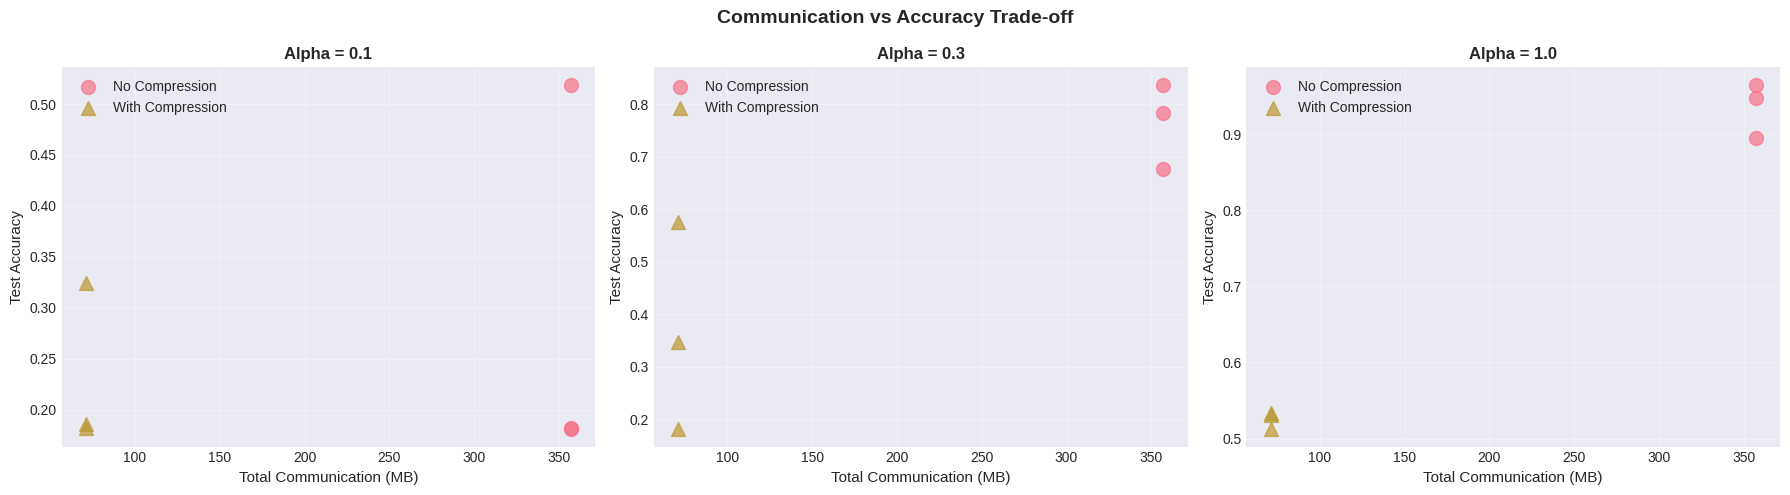

In [11]:
# Communication vs Accuracy scatter plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, alpha in enumerate(EXPERIMENT_CONFIG['alpha_values']):
    no_comp = results_by_config[(alpha, False)]
    with_comp = results_by_config[(alpha, True)]
    
    # Without compression
    no_comp_accs = [r['test_accuracy'] for r in no_comp]
    no_comp_comms = [r['total_communication_bytes'] / (1024**2) for r in no_comp]
    
    # With compression
    with_comp_accs = [r['test_accuracy'] for r in with_comp]
    with_comp_comms = [r['total_communication_bytes'] / (1024**2) for r in with_comp]
    
    axes[i].scatter(no_comp_comms, no_comp_accs, s=100, alpha=0.7, label='No Compression', marker='o')
    axes[i].scatter(with_comp_comms, with_comp_accs, s=100, alpha=0.7, label='With Compression', marker='^')
    
    axes[i].set_xlabel('Total Communication (MB)', fontsize=11)
    axes[i].set_ylabel('Test Accuracy', fontsize=11)
    axes[i].set_title(f'Alpha = {alpha}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Communication vs Accuracy Trade-off', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('compression_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

### 10.2 Communication Cost Over Rounds

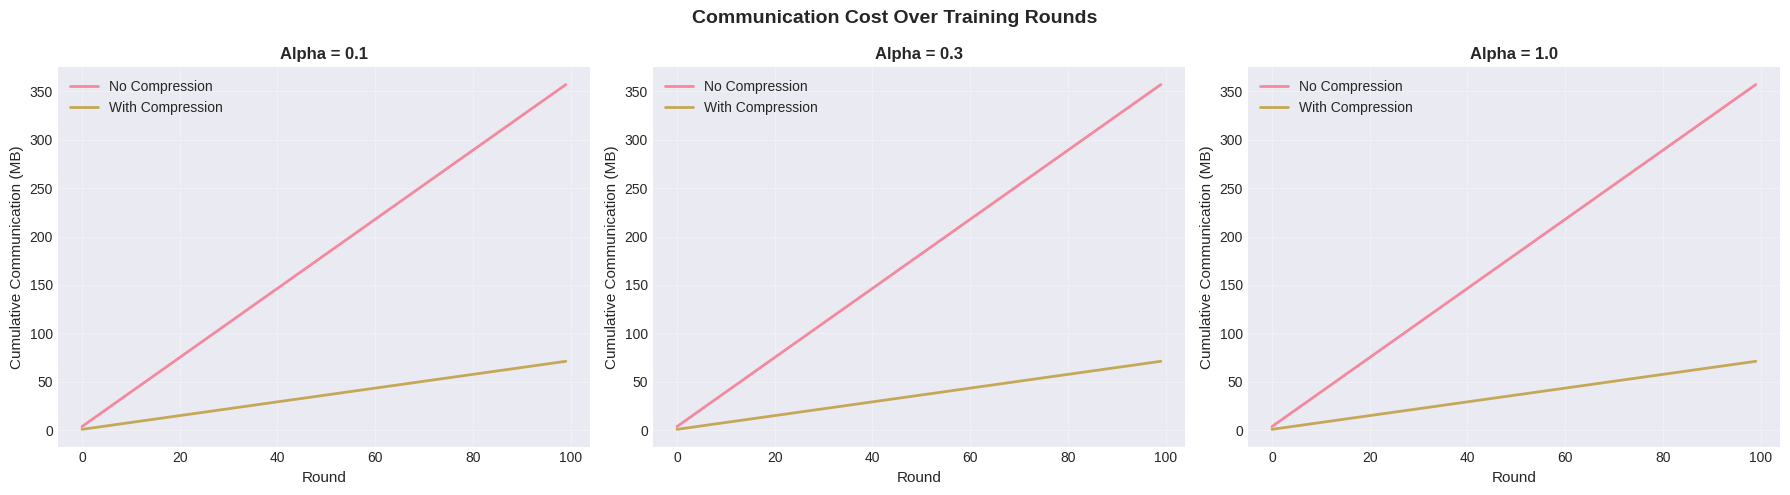

In [12]:
# Communication cost progression
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, alpha in enumerate(EXPERIMENT_CONFIG['alpha_values']):
    no_comp = results_by_config[(alpha, False)][0]  # First seed
    with_comp = results_by_config[(alpha, True)][0]
    
    rounds = np.arange(len(no_comp['history']['communication_bytes']))
    no_comp_bytes = np.array(no_comp['history']['communication_bytes']) / (1024**2)
    with_comp_bytes = np.array(with_comp['history']['communication_bytes']) / (1024**2)
    
    axes[i].plot(rounds, no_comp_bytes, label='No Compression', linewidth=2, alpha=0.8)
    axes[i].plot(rounds, with_comp_bytes, label='With Compression', linewidth=2, alpha=0.8)
    
    axes[i].set_xlabel('Round', fontsize=11)
    axes[i].set_ylabel('Cumulative Communication (MB)', fontsize=11)
    axes[i].set_title(f'Alpha = {alpha}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Communication Cost Over Training Rounds', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('communication_progression.png', dpi=300, bbox_inches='tight')
plt.show()

### 10.3 Accuracy Comparison

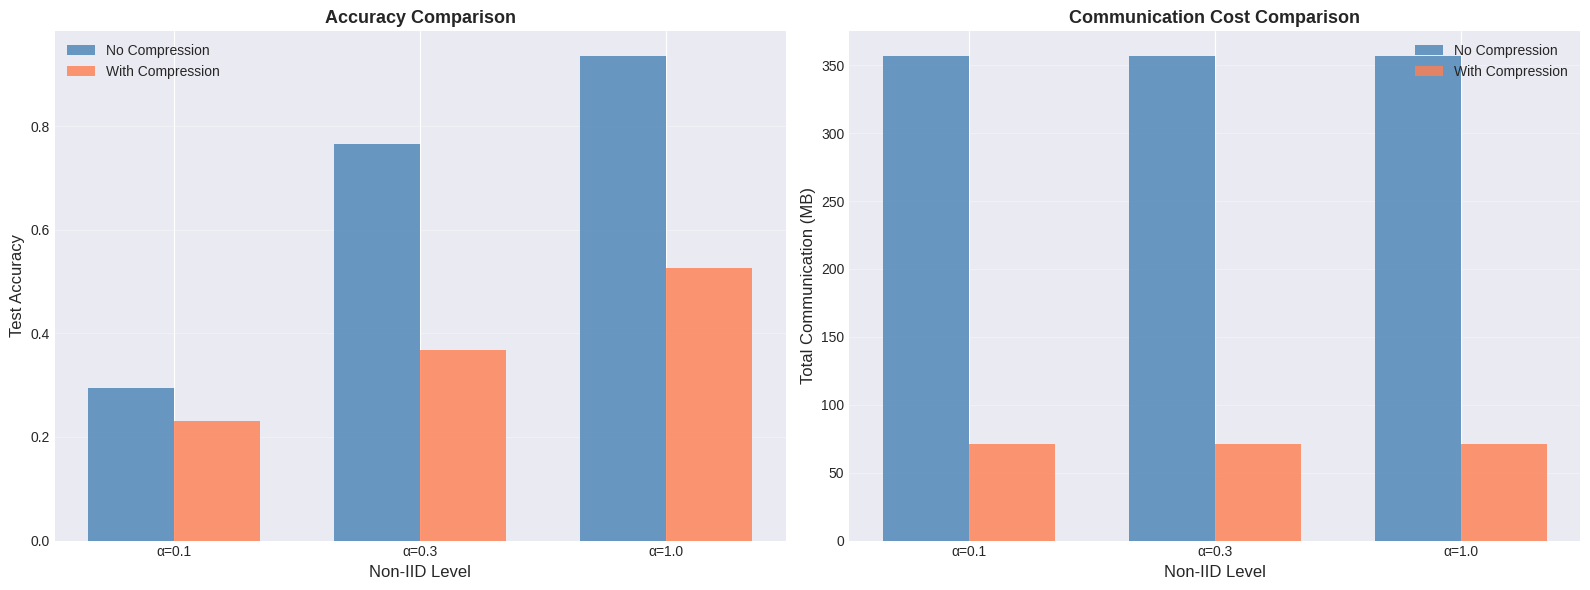

In [13]:
# Accuracy comparison bar plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
alpha_labels = [f'α={alpha}' for alpha in EXPERIMENT_CONFIG['alpha_values']]
no_comp_accs = [np.mean([r['test_accuracy'] for r in results_by_config[(alpha, False)]]) 
                for alpha in EXPERIMENT_CONFIG['alpha_values']]
with_comp_accs = [np.mean([r['test_accuracy'] for r in results_by_config[(alpha, True)]]) 
                  for alpha in EXPERIMENT_CONFIG['alpha_values']]
no_comp_comms = [np.mean([r['total_communication_bytes']/(1024**2) for r in results_by_config[(alpha, False)]]) 
                 for alpha in EXPERIMENT_CONFIG['alpha_values']]
with_comp_comms = [np.mean([r['total_communication_bytes']/(1024**2) for r in results_by_config[(alpha, True)]]) 
                   for alpha in EXPERIMENT_CONFIG['alpha_values']]

x = np.arange(len(alpha_labels))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, no_comp_accs, width, label='No Compression', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, with_comp_accs, width, label='With Compression', alpha=0.8, color='coral')
axes[0].set_xlabel('Non-IID Level', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(alpha_labels)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Communication comparison
axes[1].bar(x - width/2, no_comp_comms, width, label='No Compression', alpha=0.8, color='steelblue')
axes[1].bar(x + width/2, with_comp_comms, width, label='With Compression', alpha=0.8, color='coral')
axes[1].set_xlabel('Non-IID Level', fontsize=12)
axes[1].set_ylabel('Total Communication (MB)', fontsize=12)
axes[1].set_title('Communication Cost Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(alpha_labels)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('compression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 10.4 Training Curves Comparison

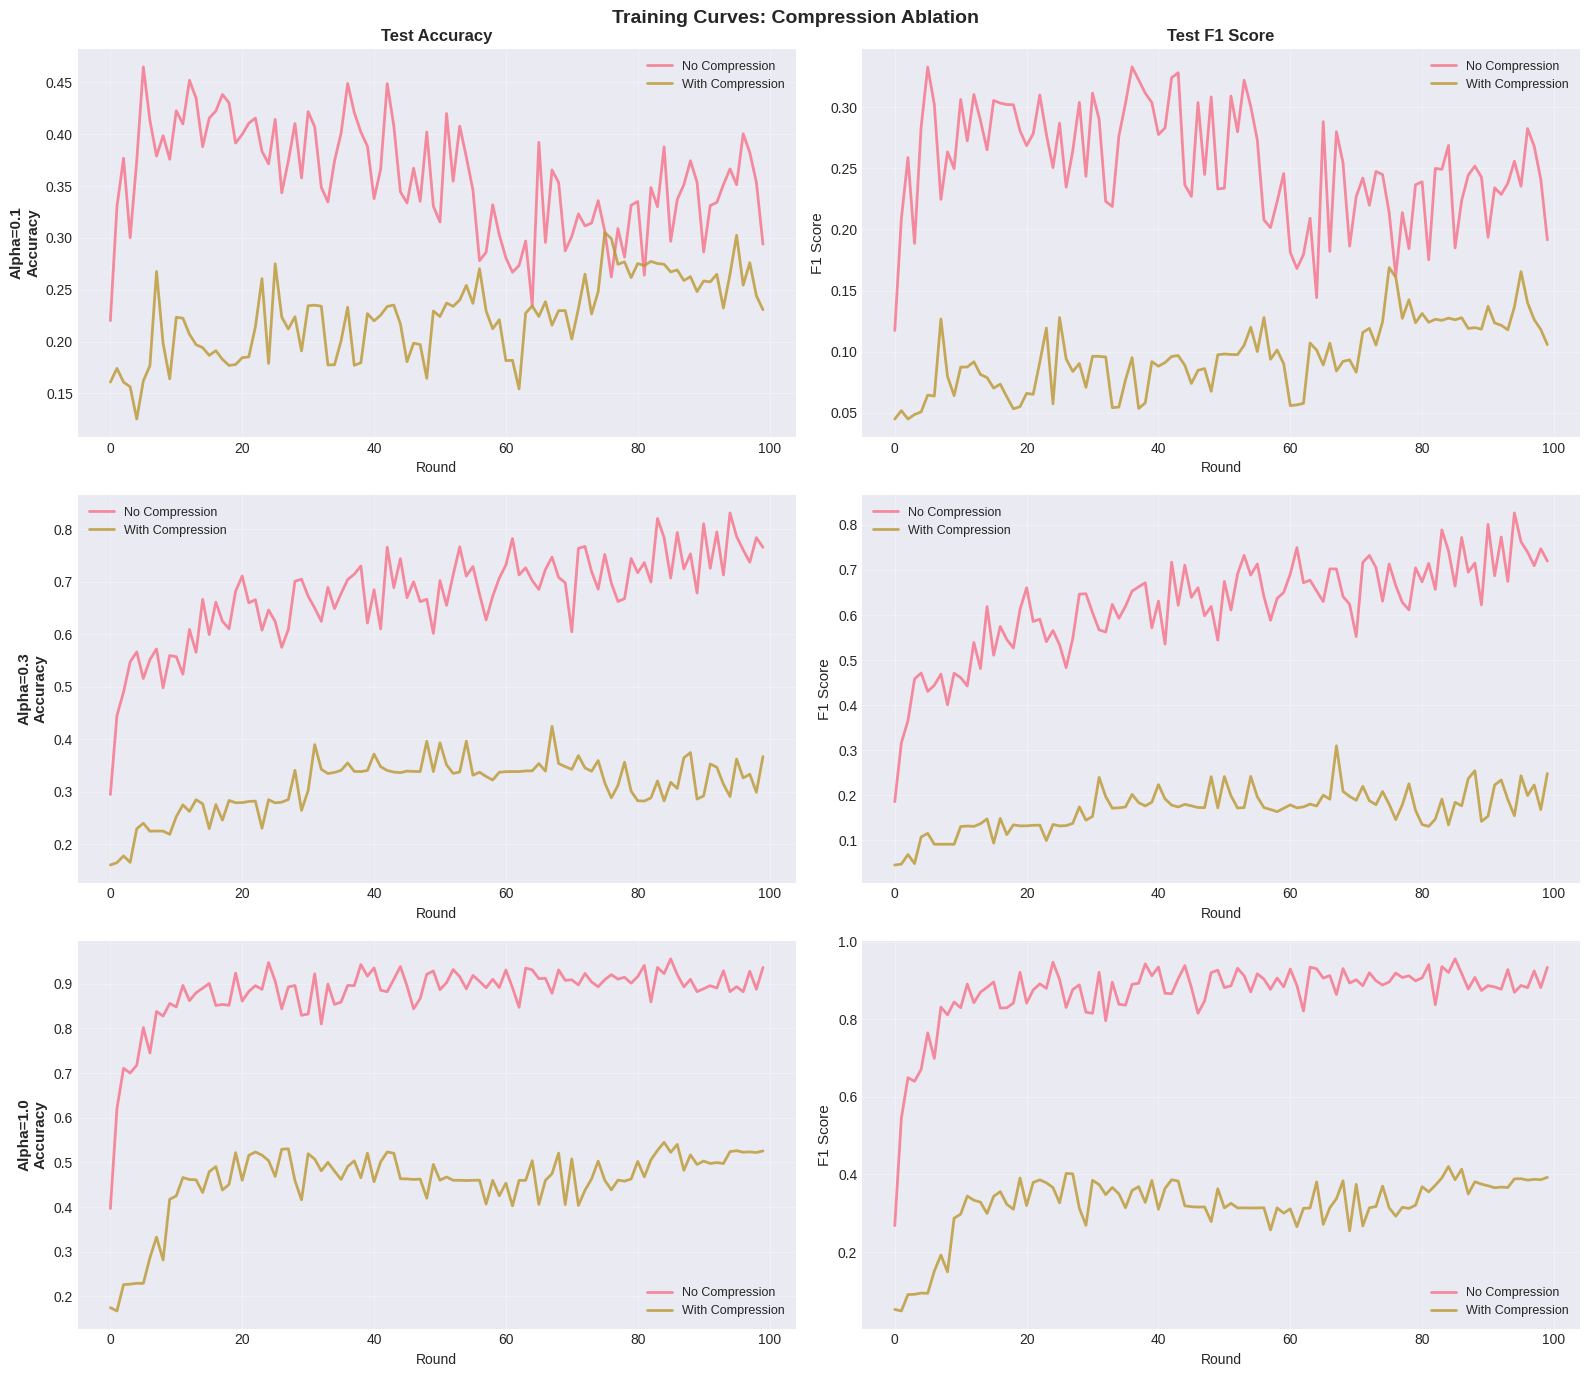

In [14]:
# Training curves with/without compression
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for i, alpha in enumerate(EXPERIMENT_CONFIG['alpha_values']):
    no_comp_results = results_by_config[(alpha, False)]
    with_comp_results = results_by_config[(alpha, True)]
    
    # Average across seeds
    no_comp_acc = np.mean([r['history']['test_acc'] for r in no_comp_results], axis=0)
    with_comp_acc = np.mean([r['history']['test_acc'] for r in with_comp_results], axis=0)
    
    no_comp_f1 = np.mean([r['history']['test_f1'] for r in no_comp_results], axis=0)
    with_comp_f1 = np.mean([r['history']['test_f1'] for r in with_comp_results], axis=0)
    
    rounds = np.arange(len(no_comp_acc))
    
    # Accuracy
    axes[i, 0].plot(rounds, no_comp_acc, label='No Compression', linewidth=2, alpha=0.8)
    axes[i, 0].plot(rounds, with_comp_acc, label='With Compression', linewidth=2, alpha=0.8)
    axes[i, 0].set_ylabel(f'Alpha={alpha}\nAccuracy', fontsize=11, fontweight='bold')
    axes[i, 0].set_xlabel('Round')
    axes[i, 0].legend(fontsize=9)
    axes[i, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[i, 1].plot(rounds, no_comp_f1, label='No Compression', linewidth=2, alpha=0.8)
    axes[i, 1].plot(rounds, with_comp_f1, label='With Compression', linewidth=2, alpha=0.8)
    axes[i, 1].set_ylabel('F1 Score', fontsize=11)
    axes[i, 1].set_xlabel('Round')
    axes[i, 1].legend(fontsize=9)
    axes[i, 1].grid(True, alpha=0.3)

axes[0, 0].set_title('Test Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Test F1 Score', fontsize=12, fontweight='bold')

plt.suptitle('Training Curves: Compression Ablation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves_compression.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Save Results

In [15]:
os.makedirs('results/fedavg_compression', exist_ok=True)

# Calculate summary statistics
summary_by_config = {}
for alpha in EXPERIMENT_CONFIG['alpha_values']:
    for comp in [False, True]:
        key = f"alpha_{alpha}_comp_{comp}"
        results = results_by_config[(alpha, comp)]
        
        summary_by_config[key] = {
            'mean_accuracy': float(np.mean([r['test_accuracy'] for r in results])),
            'std_accuracy': float(np.std([r['test_accuracy'] for r in results])),
            'mean_f1': float(np.mean([r['test_f1'] for r in results])),
            'mean_communication_mb': float(np.mean([r['total_communication_bytes']/(1024**2) for r in results])),
            'std_communication_mb': float(np.std([r['total_communication_bytes']/(1024**2) for r in results]))
        }

output = {
    'experiment_config': EXPERIMENT_CONFIG,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'device': str(device),
    'summary_by_config': summary_by_config,
    'runs': [
        {
            'alpha': r['alpha'],
            'seed': r['seed'],
            'compression': r['compression'],
            'test_accuracy': float(r['test_accuracy']),
            'test_f1': float(r['test_f1']),
            'communication_mb': float(r['total_communication_bytes']/(1024**2))
        }
        for r in all_results
    ]
}

with open('results/fedavg_compression/results.json', 'w') as f:
    json.dump(output, f, indent=2)

results_df.to_csv('results/fedavg_compression/summary.csv', index=False)

print("\nResults saved:")
print("  - results/fedavg_compression/results.json")
print("  - results/fedavg_compression/summary.csv")
print("\nVisualizations saved:")
print("  - compression_tradeoff.png")
print("  - communication_progression.png")
print("  - compression_comparison.png")
print("  - training_curves_compression.png")


Results saved:
  - results/fedavg_compression/results.json
  - results/fedavg_compression/summary.csv

Visualizations saved:
  - compression_tradeoff.png
  - communication_progression.png
  - compression_comparison.png
  - training_curves_compression.png
